# Group #3
- Beatrice Nobile
- Bertrand Leclercq
- Théophile Tolani

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from csv import writer
import datetime

# Import data
Import the data and create a Pandas data frame with it.

In [2]:
directory = "/Users/beatricenobile/Documents/Sapienza/Second Year/Algorithmic Methods for Data Mining/Homeworks/Homework 2/2019-Oct.csv"
directory2 = "/Users/beatricenobile/Documents/Sapienza/Second Year/Algorithmic Methods for Data Mining/Homeworks/Homework 2/2019-Nov.csv"

october = pd.read_csv(directory, header='infer', parse_dates=['event_time'], date_parser=pd.to_datetime)
november = pd.read_csv(directory2, header='infer', parse_dates=['event_time'], date_parser=pd.to_datetime)
data = pd.concat([october, november], ignore_index=True)

data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00+00:00,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00+00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01+00:00,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01+00:00,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04+00:00,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [3]:
data.shape

(109950743, 9)

In [4]:
lst = [october, november]
del october, november
del lst

---

# Question 1

***A marketing funnel describes your customer’s journey with your e-commerce. It may involve different stages, beginning when someone learns about your business, when he/she visits your website for the first time, to the purchasing stage, marketing funnels map routes to conversion and beyond. Suppose your funnel involves just three simple steps: 1) view, 2) cart, 3) purchase. Which is the rate of complete funnels?***

Since we don't need all the columns, we are only going to consider the ones we care about, namely [event_type, product_id, user_id]. Once we have these, we're probably going to have a lot of duplicates, since each user could have viewed, added to cart or purchased a product more than once, but what we are interested in is only if they have undergone the complete process, so we can drop all of these duplicates. Once we have the cleaned dataset, we can see whether each combination of [product_id, user_id] has all three event types or not and compute the rate of complete funnels.

Specifically, e create a new column of ones, which we will use as a counter to avoid loops, and when we group the data according to the unique combinations of [product_id, user_id], we sum that counter to see how many event types there are in each group. Those that have three, are those that completed the whole funnel. This heuristics allows us not to loop through the dataset, and save more than 20 minutes in running time.

In [5]:
# Select the data we need and clean it 
sub_df = data.loc[:, ["event_type", "product_id", "user_id"]]
sub_df = sub_df.drop_duplicates()

# Creation of the counter
counting = np.ones(sub_df.shape[0])
sub_df['counting'] = counting

# Grouping and counting
sub_df = pd.DataFrame(sub_df.groupby(['product_id', 'user_id'])['counting'].sum())
tot_events = sub_df.groupby(['product_id', 'user_id']).ngroups
complete_funnels = (sub_df.query('counting==3')).shape[0]

rate_complete_funnels = round(complete_funnels/tot_events, 3)

print("The rate of complete funnels is:", rate_complete_funnels)

The rate of complete funnels is: 0.015


##### The rate of complete funnels is quite low, which means that most of the traffic in the e-store is mainly views, or maybe also 'carting', but without final purchases. Later we will see though that there are also elements that get purchased without completing the full cart, but still, as we will see in our next question, most of the users only view the products. 

As we go on, since the dataset is so big and we will be creating sub-datasets in order to avoid working with the whole of it, and also to filter our data according to our needs, we are going to delete anything we create as soon as we use it, so as to free up memory usage.

In [6]:
del sub_df

# Question 1.1

***What’s the operation users repeat more on average within a session? Produce a plot that shows the average number of times users perform each operation (view/removefromchart etc etc).***

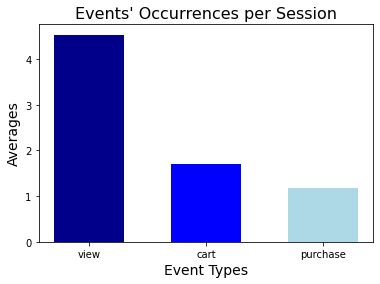

In [7]:
# We count each event type per each session
event_per_session = pd.DataFrame(data.value_counts(subset = ["user_session", "event_type"], 
                                                   sort = False), columns = ["count"])
event_per_session.reset_index(level=["event_type"], inplace=True)

# We then groupby event type and compute the mean
averages = event_per_session.groupby(by = "event_type", sort = False).mean().to_dict()
averages = averages["count"]

# Plot
plt.bar(*zip(*averages.items()), width= 0.6, color = ["darkblue", "blue", "lightblue"])
plt.xlabel("Event Types", fontdict={'fontsize': 14}) 
plt.ylabel("Averages", fontdict={'fontsize': 14}) 
plt.title("Events' Occurrences per Session", fontdict={'fontsize': 16})
plt.show()

##### As we can see from the graph, we now have proof that most of the traffic is simply "view", and it seems that less than half of it is 'cart' and about a quarter is 'purchase'.  Yet, we are considering the mean events per session, and as we will later see, most of the users will view the product a lot of times during their purchases (and even without purchases)

In [8]:
del event_per_session

# Question 1.2

***How many times, on average, a user views a product before adding it to the cart?***

First of all, we need to take into consideration the fact that a user might view the product even after adding it to cart or even after purchasing it. Below we see an example:

In [9]:
data.loc[(data["product_id"] == 5100816) & (data["user_id"] == 550121407)]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
315,2019-10-01 00:04:47+00:00,view,5100816,2053013553375346967,NaN,xiaomi,29.51,550121407,6f623695-9581-4633-813f-825b8760c7ae
331,2019-10-01 00:05:14+00:00,cart,5100816,2053013553375346967,NaN,xiaomi,29.51,550121407,6f623695-9581-4633-813f-825b8760c7ae
346,2019-10-01 00:05:29+00:00,view,5100816,2053013553375346967,NaN,xiaomi,29.51,550121407,6f623695-9581-4633-813f-825b8760c7ae
500717,2019-10-01 10:23:22+00:00,view,5100816,2053013553375346967,NaN,xiaomi,29.51,550121407,127baff6-a637-4c93-b4ca-864ca4d54373
501711,2019-10-01 10:24:18+00:00,view,5100816,2053013553375346967,NaN,xiaomi,29.51,550121407,127baff6-a637-4c93-b4ca-864ca4d54373


Since we need to understand how many times the user views the product **before** adding it to the cart, we must count only those occurrences that come before that event. We first select only the columns we are interested in, and create two groups, one for the "view" event, and one for the "cart" event. Then we compare the two groups, merge them on the base of the product_id and the user_id and then subtract from the resulting dataframe the rows that come after the time when the product was added to the cart. Finally, we count those rows.

In [10]:
# Filter the data
sub_df = data.loc[:, ["event_time", "event_type", "product_id", "user_id"]]

# Create the groups we need 
cart_products = sub_df.query('event_type=="cart"').product_id

group_cart = sub_df.query('event_type=="cart"').groupby(['user_id', 'product_id'])

group_view = (sub_df[sub_df.product_id.isin(cart_products)]
              .query('event_type=="view"').groupby(['user_id', 'product_id']))

counts = []
# Select each [product_id, user_id] combination belonging to cart group
for idx, group1 in group_cart:
    try:
        # retrieve corresponding views
        group2 = group_view.get_group(idx)
    except KeyError:
        # handle rare case of a cart event with no view event
        counts.append(0)
        continue
        # we consider only those views that occurred before adding to cart, and count
    counts.append(group2.loc[group2.event_time.lt(group1.event_time.iloc[0]), 'event_type'].count() )

result_1_2 = round(sum(counts)/len(counts), 2)
print(f"On average an user views the product {result_1_2} times before adding it to the cart.")

On average an user views the product 2.89 times before adding it to the cart.


In [11]:
del group_view

# Question 1.3

***What’s the probability that products added once to the cart are effectively bought?***

We already have the sub_dataframe with only the columns we are interested on (sub_df). We also already know which are the products that have been added to the cart by users (cart_products). Based on this group of products, we can see which are the products that have been purchased after being carted. Then, we use exactly the same method as before, but now, we check for what has appened after adding the product to the cart. Another difference with respect to before is that we are not really interested in knowing how many times they purchase the product, but only if they do.

In the mean time, we prepare the ground for question 1.4, and we extract all the information on those customers that have added to the cart a certain product, but have not proceeded into purchasing it. To do this we will use a csv_writer method, because we found that this method was much faster than others we tried.

In [12]:
# Create the groups we need 
group_purchased = (sub_df[sub_df.product_id.isin(cart_products)]
              .query('event_type=="purchase"').groupby(['user_id', 'product_id']))

bought = []

# We prepare the writer [for question 1.4]
output = StringIO()
csv_writer = writer(output)

# Select each [product_id, user_id] combination belonging to cart group
for idx, group1 in group_cart:
    try:
        # retrieve corresponding purchases
        group2 = group_purchased.get_group(idx)
    except KeyError:
        # these are the cases of 'cart' events without 'purchase' events 
        bought.append(0)
        # we add these to the "removed" group
        csv_writer.writerow(group1.to_numpy()[0])
    # we are considering only those purchases after cart event (there could be more than 1)
    if group2.loc[group2.event_time.gt(group1.event_time.iloc[0]), 'event_type'].count() > 0:
        bought.append(1)
        
# build up the 'removed' group with from the csv we created [for question 1.4]
output.seek(0) 
removed = pd.read_csv(output, header=None, sep='\n')
removed = removed[0].str.split(',', expand=True)
removed.columns = ["event_time", "event_type", "product_id", "user_id"]
removed[["product_id", "user_id"]] = removed[["product_id", "user_id"]].apply(pd.to_numeric)

# we count how many products were purchased after cart event
result_1_3 = round(sum(bought)/len(bought), 2)

print("The probability of purchasing a product after having added it to the cart is:", result_1_3)

The probability of purchasing a product after having added it to the cart is: 0.55


##### It seems like only a bit over half the time the product that has been added to cart is then purchased by the customer. This is more or less in line with our previous findings on the events per session frequencies, where it also seemed like the purchase event was a bit more than half the cart event, especially when we consider that some products are bought more than once, then the proportions would seem correct. 

In [13]:
del group_purchased

# Question 1.4

***What’s the average time an item stays in the cart before being removed?***

The first thing we notice here is that the dataset doesn't actually contain "removefromcart" event. Yet, as suggested by the author of the dataset, we can figure out removed from cart products as the difference between purchase and cart events. 

In [14]:
data.loc[data["event_type"] == "removefromcart"]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session


Again, we can't use aggregate functions, because we need to consider the timing. A product can be classified as "removed from cart" only after it has been added to cart and afterwards it has not been purchased, and that is what we have built in the "removed" dataframe.

In [15]:
removed

,event_time,event_type,product_id,user_id
0,2019-11-19 10:03:47+00:00,cart,30901102,74383042
1,2019-11-12 08:04:08+00:00,cart,1005007,94566147
2,2019-11-28 08:45:14+00:00,cart,4700199,107837897
3,2019-11-28 08:52:47+00:00,cart,4700419,107837897
4,2019-11-29 05:00:04+00:00,cart,4700557,107837897
...,...,...,...,...
1226402,2019-11-30 23:37:54+00:00,cart,1002633,579963523
1226403,2019-11-30 23:41:36+00:00,cart,12703642,579964062
1226404,2019-11-30 23:44:00+00:00,cart,1005105,579965069
1226405,2019-11-30 23:52:56+00:00,cart,1004767,579967455


Quick check to see if indeed the combinations ["product_id", "user_id"] in the removed dataframe are indeed those that have added the products on the cart but not purchased them afterwards.

In [16]:
data.loc[(data["product_id"] == 4700419) & (data["user_id"] == 107837897)]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
65397558,2019-11-13 17:16:41+00:00,view,4700419,2053013560899928785,auto.accessories.videoregister,sho-me,141.25,107837897,c9ee4a4a-460e-4b66-b51f-dcacb5b66a15
105178528,2019-11-28 08:35:30+00:00,view,4700419,2053013560899928785,auto.accessories.videoregister,sho-me,141.82,107837897,f47e2575-5121-4654-8027-ba9431582dce
105181488,2019-11-28 08:37:29+00:00,view,4700419,2053013560899928785,auto.accessories.videoregister,sho-me,141.82,107837897,f47e2575-5121-4654-8027-ba9431582dce
105203329,2019-11-28 08:51:45+00:00,view,4700419,2053013560899928785,auto.accessories.videoregister,sho-me,141.82,107837897,463fd31d-8a38-4324-a9d5-c0c157a5a4db
105204812,2019-11-28 08:52:47+00:00,cart,4700419,2053013560899928785,auto.accessories.videoregister,sho-me,141.82,107837897,463fd31d-8a38-4324-a9d5-c0c157a5a4db
105871854,2019-11-28 15:57:22+00:00,view,4700419,2053013560899928785,auto.accessories.videoregister,sho-me,141.82,107837897,38554047-29fd-4ef9-b858-81390568f740
105873907,2019-11-28 15:58:23+00:00,cart,4700419,2053013560899928785,auto.accessories.videoregister,sho-me,141.82,107837897,38554047-29fd-4ef9-b858-81390568f740
106592734,2019-11-29 05:07:02+00:00,view,4700419,2053013560899928785,auto.accessories.videoregister,sho-me,141.82,107837897,acab59ac-e09b-40cf-b024-7f8d1ee7a0fa
106603664,2019-11-29 05:13:49+00:00,view,4700419,2053013560899928785,auto.accessories.videoregister,sho-me,141.82,107837897,8d09c3a7-ba2f-457b-bf2e-c996cff745b7


So now we know which products that had been added to the cart have not afterwards been purchased, and hence that at some point must have been removed from the cart. To compute how much time the product has stayed in the cart, we can look at the last time the user has viewed the product, after having added it to the cart, and once he/she has not viewed it anymore, then we suppose that they have removed it from the cart. For those that do not view the product after the cart, we assume that the element has immediately been removed from the cart.

Therefore, we now need to retreive the last time the product has been viewed for each [user_id, product_id] pair that has been classified as "removed_from_cart".

In [17]:
# Filter and clean data
removed['event_time'] = pd.to_datetime(removed['event_time'])
# Create the groups we need 
removed_products = list(removed.product_id)

group_removed = removed.groupby(['product_id', 'user_id'])

# we only take the last view
last_view = (sub_df[sub_df.product_id.isin(removed_products)]
              .query('event_type=="view"').groupby(['user_id', 'product_id']).last()).reset_index()
last_view = last_view.groupby(['product_id', 'user_id'])

In [18]:
time_in_cart = []

# Select each [product_id, user_id] combination belonging to removed group
for idx, group1 in group_removed:
    try:
        # Retrieve corresponding last view
        group2 = last_view.get_group(idx)
        # If the last view occurred after cart event compute the time difference
        if list(group2.event_time)[0] > list(group1.event_time)[0]:
            time_in_cart.append(((pd.Timedelta((list(group2.event_time)[0] 
                                               - list(group1.event_time)[0])).value)/1000000000))
        else:
            # If the product wasn't viewed after cart event, we assume it was immediately eliminated
            time_in_cart.append(0)
    except KeyError:
        # cases where the product has not been viewed either before or after cart event
        time_in_cart.append(0)

result_1_4 = sum(time_in_cart) / len(time_in_cart)

sec = datetime.timedelta(seconds = result_1_4)
d = datetime.datetime(1,1,1) + sec

print(f"On average before being removed a product stays in the cart:")
print("%d Day and %d:%d:%d" % (d.day-1, d.hour, d.minute, d.second))

On average before being removed a product stays in the cart:
1 Day and 18:15:14


##### Provided that our assumptions are correct, meaning that the user will view the product one last time before deciding whether to remove it or not, and that if he/she doesn't view the product again, it means that he/she has removed it from the cart immediately (maybe due to a mistake for example), then it seems that the product stays in the cart for about 2 days before being removed. 

In [19]:
lst = [removed, group_removed, last_view]
del removed, group_removed, last_view
del lst

# Question 1.5

***How much time passes on average between the first view time and a purchase/addition to cart?***

To answer this question, we first create three different dataframes that are grouped by the [product_id, user_id] combination, and that contain only the first occurrence of each event type. Indeed, a user may buy a product more than once, may also add it to cart, then remove it, and then add it again, etc...

Once we have these subgroups, we can compute the time difference between each event's first occurrence.

In [20]:
# Filter the date according to needs: get the first occurrence for each event.
first_view = (sub_df.query('event_type=="view"').groupby(['user_id', 'product_id']).first()).groupby(['user_id', 'product_id'])
first_cart = (sub_df.query('event_type=="cart"').groupby(['user_id', 'product_id']).first()).groupby(['user_id', 'product_id'])
first_purchase = (sub_df.query('event_type=="purchase"').groupby(['user_id', 'product_id']).first()).groupby(['user_id', 'product_id'])

In [21]:
# Compute time difference between first view and cart event.
time_cart = []

for idx, group1 in first_cart:
    try:
        group2 = first_view.get_group(idx)
        if list(group1.event_time)[0] > list(group2.event_time)[0]:
            time_cart.append((pd.Timedelta((list(group1.event_time)[0] 
                                            - list(group2.event_time)[0])).value)/1000000000) 
    except:
        continue

        
result_1_5_1 = sum(time_cart) / len(time_cart)

sec_1 = datetime.timedelta(seconds = result_1_5_1)
d_1 = datetime.datetime(1,1,1) + sec_1

print(f"On average, the time it takes a user to add a product to the cart after the first view is:")
print("%d Days and %d:%d:%d" % (d_1.day-1, d_1.hour, d_1.minute, d_1.second))

On average, the time it takes a user to add a product to the cart after the first view is:
2 Days and 9:15:37


In [22]:
# Compute time difference between first view and purchase event.
time_purchase = []

for idx, group1 in first_purchase:
    try:
        group2 = first_view.get_group(idx)
        if list(group1.event_time)[0] > list(group2.event_time)[0]:
            time_purchase.append((pd.Timedelta((list(group1.event_time)[0] 
                                            - list(group2.event_time)[0])).value)/1000000000)
    except:
        continue
        

result_1_5_2 = sum(time_purchase) / len(time_purchase)

sec_2 = datetime.timedelta(seconds = result_1_5_2)
d_2 = datetime.datetime(1,1,1) + sec_2

print(f"On average, the time it takes a user to purchase a product after the first view is:")
print("%d Days and %d:%d:%d" % (d_2.day-1, d_2.hour, d_2.minute, d_2.second))

On average, the time it takes a user to purchase a product after the first view is:
1 Days and 19:13:56


##### It seems it takes almost half the time for users to decide to buy the products, than it takes them to add it to cart. This might seem strange, but if we consider that half the time a product is added to cart it is actually not purchased, then the numbers seem more correct, because we add for the indecision of those half times the product is not actually purchased. 

In [23]:
lst = [first_view, first_cart, first_purchase, sub_df]
del first_view, first_cart, first_purchase, sub_df
del lst

---

# Question 2

***What are the categories of the most trending products overall? For each month visualize this information through a plot showing the number of sold products per category.***

For this question, we need only the data from the sold products, which mean the data where the event_type is 'purchase'. For the category, we use the category_code which is the meaningful name of the category (in the format category.subcategory, so we apply a function to extract only the category name). The best visualisation for this data is the "bar" plot.

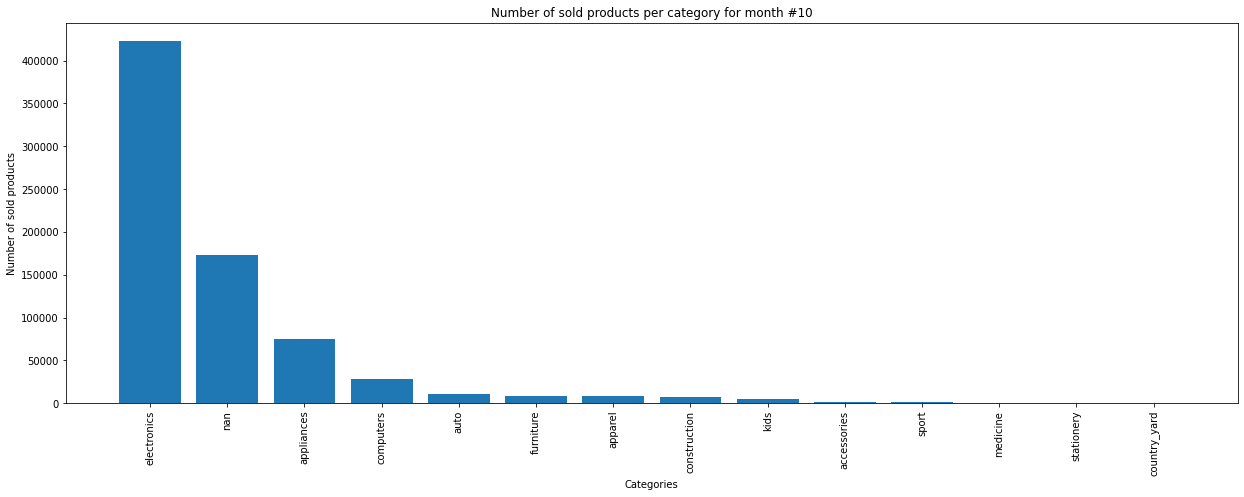

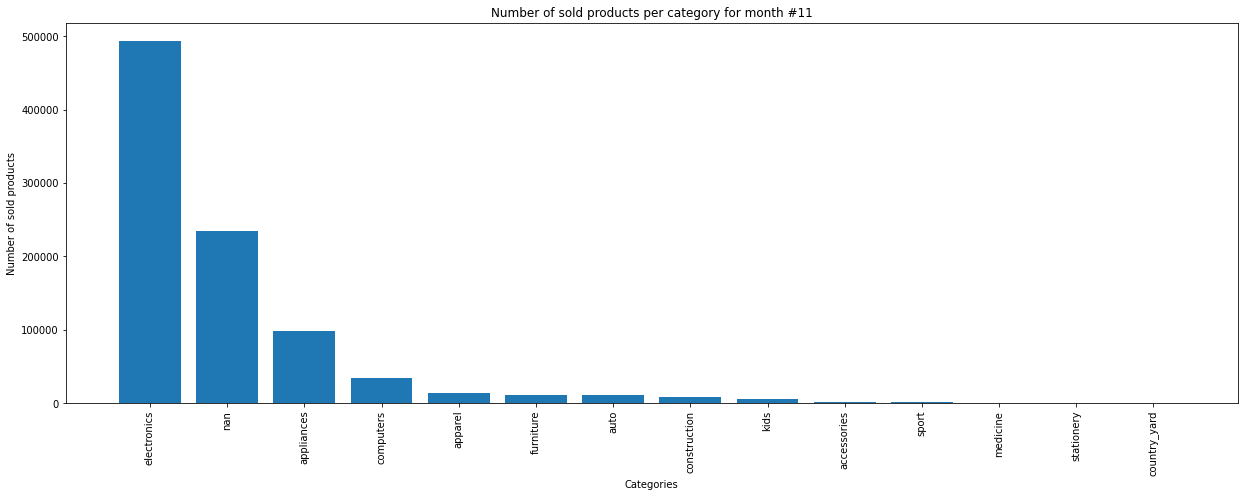

In [24]:
# Use only the data from purchase (= sold products) 
purchases = data[data.event_type == 'purchase'].copy()

# Extract the category name from the category_code attribute
purchases['category_code'] = purchases['category_code'].apply(lambda x: str(x).split('.')[0])

purchasesByMonth = purchases.groupby([purchases.event_time.dt.month])

# Group the data by month and for each month, make a plot
for month, frame in purchasesByMonth:
    
    categoriesCount = frame['category_code'].value_counts()
    
    x = list(map(str, categoriesCount.index))
    heigths = categoriesCount.values
    
    plt.figure(figsize=(21,7))
    plt.bar(x, heigths)
    plt.title(f'Number of sold products per category for month #{month}')
    plt.ylabel('Number of sold products')
    plt.xlabel('Categories')
    plt.xticks(rotation=90)
    plt.show()

##### With those plot, we can see that the order and repartition between the categories in both month are quite similar. We can also see that for the first three categories, there is more sold products in November than in October (which is not perturbing as there is more rows in the November dataset, thus more chances to have more purchases). This can also be seen in other categories, but the change on the plot is too small to be certain. We also learn that there is quite a lot of sold products with no category (around 175.000 for October and around 230.000 for November). So to answer the question, the categories of the most trending products are electronics, appliances and computers for both months.

In [25]:
del purchases

# Question 2.1

***Plot the most visited subcategories.***

This is similar from the previous question, except that we need the visits and not the sold data (so the data where the event_type is 'view') and we want all subcategories (and not only categories).

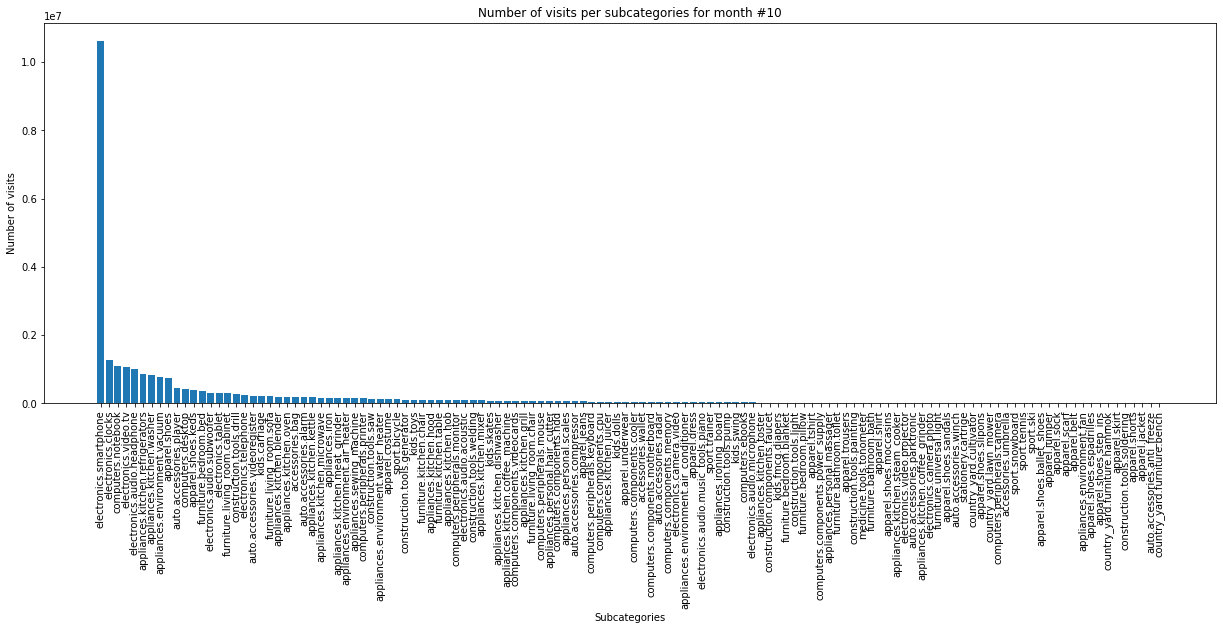

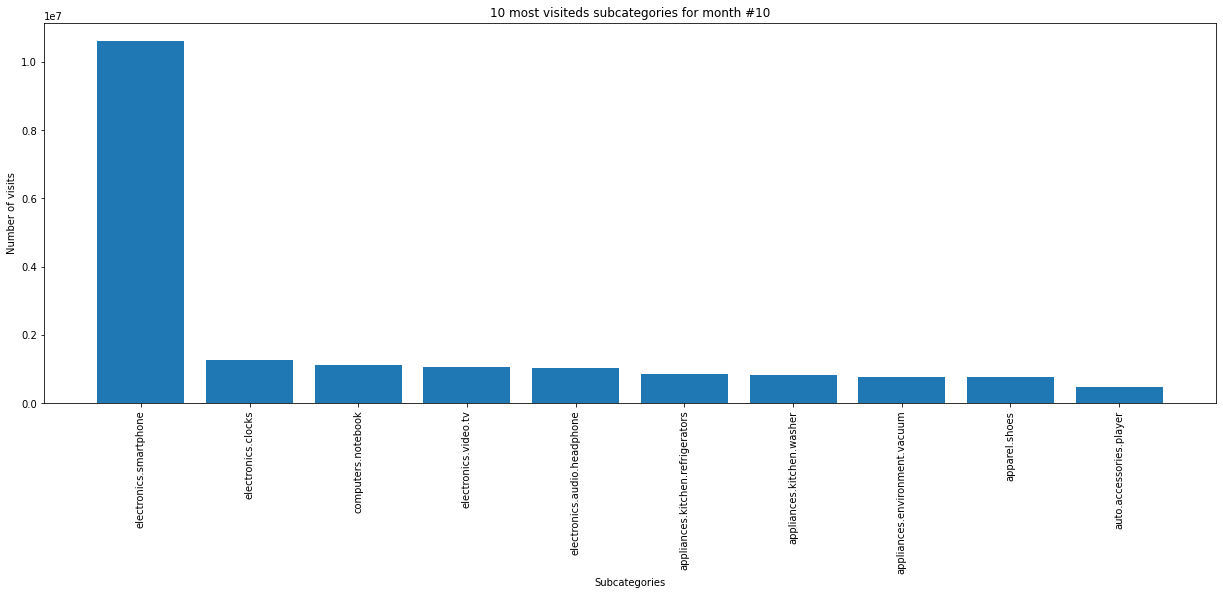

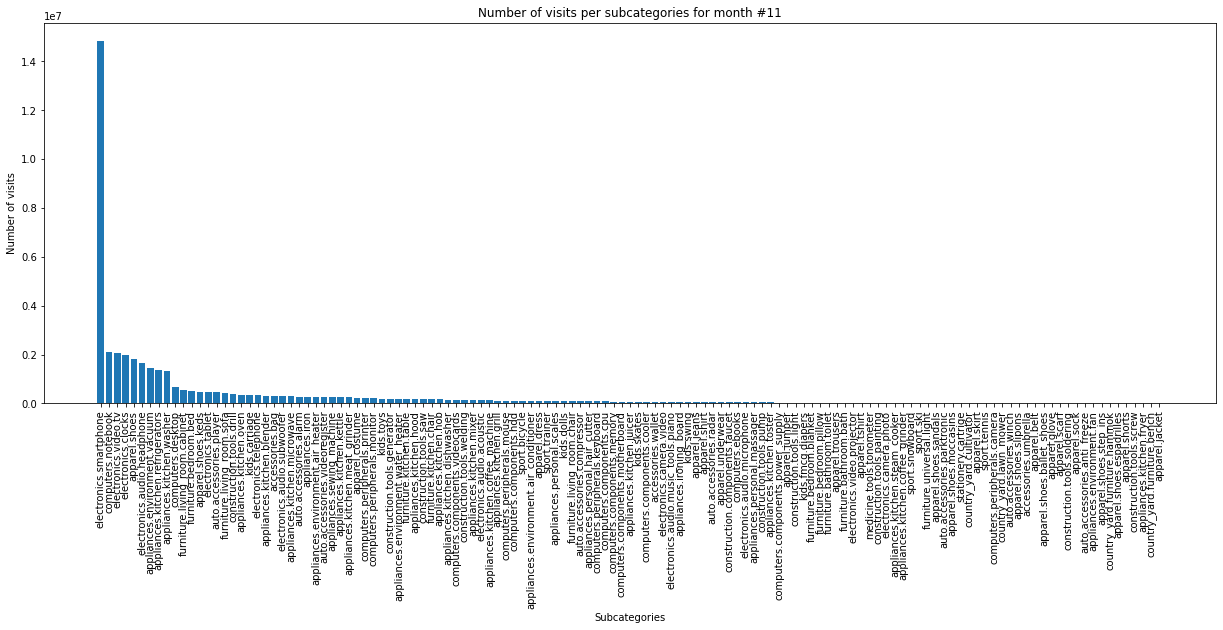

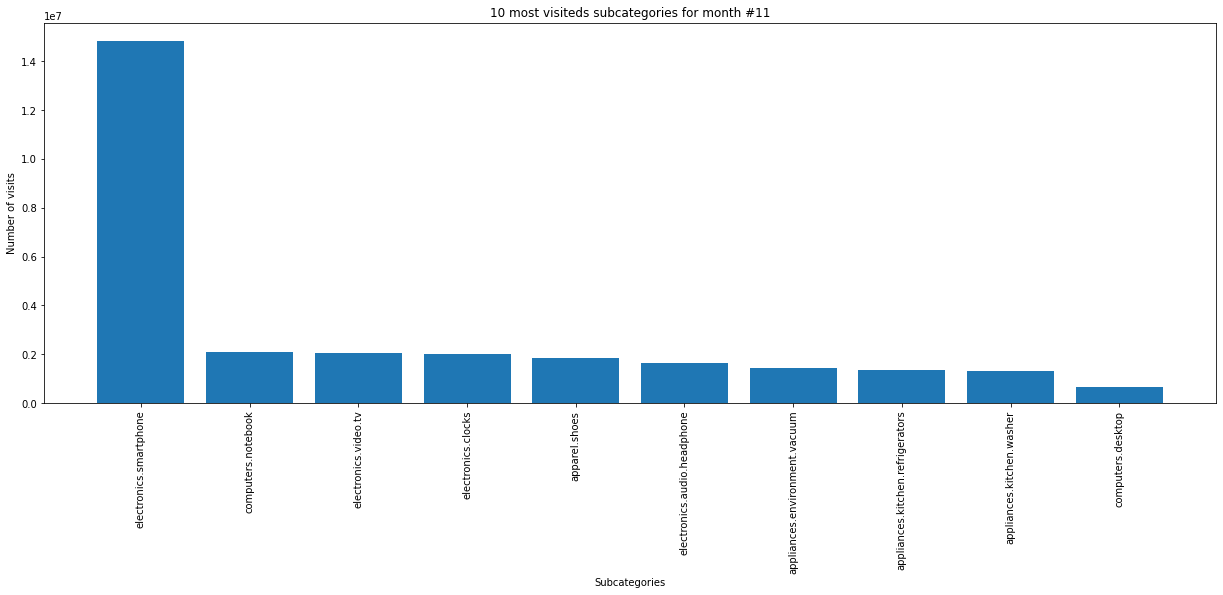

In [26]:
# Use only the data from view (= visited products) 
visits = data[data.event_type == 'view'].copy()

# Group the data by month and for each month
for month, frame in visits.groupby([visits.event_time.dt.month]):
    
    categoriesCount = frame['category_code'].value_counts()
    
    x = list(map(str, categoriesCount.index))
    heigths = categoriesCount.values
    
    # Make a plot with all the subcategories.
    plt.figure(figsize=(21,7))
    plt.bar(x, heigths)
    plt.title(f'Number of visits per subcategories for month #{month}')
    plt.ylabel('Number of visits')
    plt.xlabel('Subcategories')
    plt.xticks(rotation=90)
    plt.show()

    # Make a plot with the 10 most visited subcategories
    plt.figure(figsize=(21,7))
    plt.bar(x[:10], heigths[:10])
    plt.title(f'10 most visiteds subcategories for month #{month}')
    plt.ylabel('Number of visits')
    plt.xlabel('Subcategories')
    plt.xticks(rotation=90)
    plt.show()

##### Those plots show us that smartphone are the most visited products and by far (with at least 10.000.000 visits more than the second subcategory for both months). If we look at the 10 most visited subcategories, we see that 4 of the subcategories are from electronics and 3 from appliances. This can explain why they are the two category with the most sold products. Another thing we learn is that there is a lot more visit in a category that sold products: If we take the 10 most visited subcategories of October and sum up the visit for the electronics category, we are around 13.000.000 visits, but we have only a bit more than 400.000 sold products.

In [27]:
del visits

# Question 2.2

***What are the 10 most sold products per category?***

For this question, I reuse the `purchasesByMonth` variable from the question 2. For each month, we group the data by category and then for each category, we counts the number of product and print the 10 higher number whith the id of the product.

In [28]:
for month, frame in purchasesByMonth:
    
    print(f'Month {month}')
    print('----------------------------------')
    
    for categoryCode, frame2 in frame.groupby([frame.category_code]):
        
        print(f'Categorie: {categoryCode}')
        print(frame2['product_id'].value_counts().head(10))
        print()

Month 10
----------------------------------
Categorie: accessories
18300155    63
18300021    34
52900016    31
28300780    24
49800017    23
28300432    21
18300595    17
28400774    16
18300496    16
18300214    16
Name: product_id, dtype: int64

Categorie: apparel
28718083    72
28715756    46
28712682    45
28715827    40
28717034    39
28715757    39
28716983    38
28703609    38
28715829    38
54900011    37
Name: product_id, dtype: int64

Categorie: appliances
3700926    1675
3600661    1482
3600163    1017
3600666     877
2900536     831
3601405     768
3601485     627
2701657     566
3601244     559
3701134     543
Name: product_id, dtype: int64

Categorie: auto
6000094    785
4700478    411
5701128    382
6000227    360
5701166    304
4700630    300
4700589    235
6000229    214
6000004    206
5700518    165
Name: product_id, dtype: int64

Categorie: computers
1307310    1003
1307073     864
1307366     722
1307067     651
1306650     649
1307074     416
1307188     378
13071

##### There is not a lot to say about this print except that for each month, we see the 10th item in the electronics has been sold more times than any first items of any other category. We also see that 9 products are in the 10 mosts sold products of the category "electronics" in both month. And only the "apparel" category has nothing in commun between the two months. Another thing that we can learn (with a bit more search) is that the 3 most sold products (thus the 3 first in the "electronics" category) for both months are smartphones. This can be link to the visits as the first subcategory in visits is "smartphone".

In [29]:
del purchasesByMonth

---


# Question 3

***For each category, what’s the brand whose prices are higher on average?***

# Question 3.1

***Write a function that asks the user a category in input and returns a plot indicating the average price of the products sold by the brand.***

For this question, we fist extract the category name from the category_code attribute, print all possible category and wait for an input from the user (which need to be in the list of category). Then, we extract the data from the given category, group the category data by brand and compute the price mean before plotting the result in a 'bar' plot (which is the more suitable for this visualisation).

Enter a category (nan, appliances, furniture, computers, electronics, apparel, construction, auto, kids, sport, accessories, medicine, stationery, country_yard):
furniture


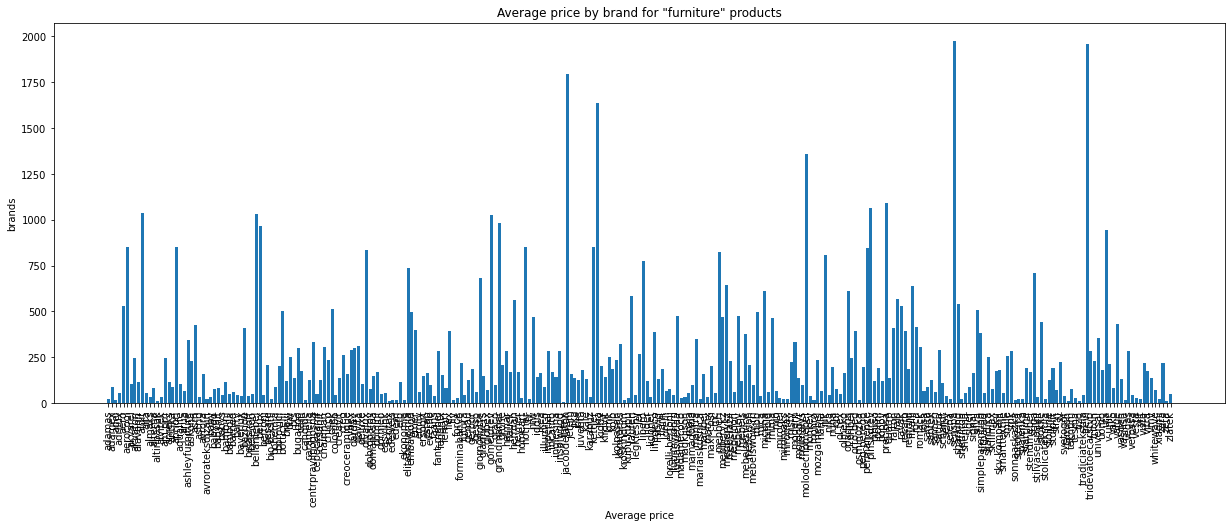

In [30]:
dataCopy = data.copy()

# Extract the category name from the category_code attribute
dataCopy['category_code'] = dataCopy['category_code'].apply(lambda x: str(x).split('.')[0])    

# Ask the user for a category and check if it exists
while True:
    print(f'Enter a category ({", ".join(dataCopy["category_code"].unique())}):')
    category = input()
    if category in dataCopy["category_code"].unique():
        break

# Extract the data from the given category
categoryData = dataCopy[dataCopy.category_code == category]
# Group the category data by brand and compute the price mean
brandPriceAverage = categoryData.groupby([categoryData.brand]).price.mean()

# Plot the price mean / brand
x = brandPriceAverage.index
heigths = brandPriceAverage.values

plt.figure(figsize=(21,7))
plt.bar(x, heigths)
plt.title(f'Average price by brand for "{category}" products')
plt.ylabel('brands')
plt.xlabel('Average price')
plt.xticks(rotation=90)
plt.show()

In [31]:
del category, categoryData, brandPriceAverage, x, heigths

# Question 3.2

***Find, for each category, the brand with the highest average price. Return all the results in ascending order by price.***

For this question, we group the data by category and by brand and we compute the price mean. The for each category, we apply a sort_value to sort the brand and their mean price in descending order and get the first one (thus the brand with the highest mean price). After that, we sort the category in ascending order.

In [32]:
dataCopy = dataCopy.groupby([dataCopy.category_code, dataCopy.brand]).price.mean()
dataCopy.groupby('category_code', group_keys=False).apply(lambda x: x.sort_values(ascending=False).head(1)).sort_values()

category_code  brand        
medicine       omron              52.655490
stationery     xerox              66.670000
accessories    weekend           690.505716
country_yard   viking            746.174484
apparel        sergiorossi      1018.397273
auto           schneider        1110.101860
kids           hartan           1801.820000
furniture      senspa           1976.539630
electronics    rado             2062.926100
construction   helix            2199.047736
computers      dreammachines    2221.466373
appliances     climadiff        2261.951167
nan            yjfitness        2344.980000
sport          pinarello        2533.238401
Name: price, dtype: float64

##### In this print, we seen that the brand "pinarello" from the "sport" category is the one with the highest average price. Those results can be check using the function of Question 3.1. We also see that there are two big gaps, one between the "stationery" and the "accessories" categories (around 630), and the second between the "auto" and the "kids" categories (around 690).

In [33]:
del dataCopy

---

# Question 4

***How much does each brand earn per month? Write a function that given the name of a brand in input returns, for each month, its profit. Is the average price of products of different brands significantly different?***

To answer this question, we group by months and brands, and, considering only purchased products, we average each brand's monthly profit. 

In [34]:
# Selecting purchased products only
sub_df = data.loc[:, ["event_time", "event_type", 
                      "brand", "price"]].query("event_type == 'purchase'")

# Changing the date to exclude hours, minutes and seconds
sub_df['event_time'] = sub_df['event_time'].dt.date
sub_df = sub_df.set_index(pd.DatetimeIndex(sub_df['event_time']))
sub_df.drop(['event_time', 'event_type'], axis = 1, inplace = True)

# We group by months with grouper, and then group by brands to take the mean price
sub_df = pd.DataFrame(sub_df.groupby([pd.Grouper(freq='M'), 'brand'])['price'].mean())
sub_df.reset_index(level='brand', inplace = True)

# Note those brands that did make a profit and those that didn't
brands = list(sub_df.brand.drop_duplicates())
all_brands = list(data.brand.drop_duplicates())
if len(brands) != len(all_brands):
    missing_brands = [i for i in all_brands if i not in brands]

# For a more readable output, we explicitly denote if the month is October or November 
sub_df.reset_index(inplace = True)
sub_df['event_time'] = sub_df['event_time'].dt.month
sub_df['event_time'] = sub_df.replace({'event_time': {10: 'october', 11: 'november'}})

# Finally, groupify:
g_sub_df = sub_df.groupby('brand')

After having created this filtered dataset, we have written a function that given the name of the brand will create a dictionary with months as keys and monthly profits as values. Indeed, each brand could also not have made a profit in both months, and we only create a dictionary entry for the months they did have a profit. There are also those brands that did not have any profit. For those, the function will simply tell you that in both months their profits were zero. 

In [35]:
def brand_monthly_profit(brand):
    # brand name is the key to access the group
    group = g_sub_df.get_group(brand)
    # if the brand is in the list of those that made a profit
    if brand in brands:
        #store each month's profit
        profits = {}
        for i in range(len(group)):
            profits[list(group.event_time)[i]] = list(group.price)[i]
        return profits
    else:
        print(f"{brand}'s profits for October and November are 0")

In [36]:
mean = round(sub_df.price.mean(), 2)
mini = round(sub_df.price.min(), 2)
maxi = round(sub_df.price.max(), 2)
var = round(sub_df.price.var(), 2)

print("The average profits change greatly among brands, as the variance shows.")
print(f"In fact, the variance is {var}, and indeed while the mean is {mean}, we have maximum value {maxi} and minimum {mini}.")

The average profits change greatly among brands, as the variance shows.
In fact, the variance is 55157.84, and indeed while the mean is 158.12, we have maximum value 2069.55 and minimum 0.9.


#####  Brands selling in this e-store are the most disparate, selling any kind of product, and consequently at any price. And it could be that a brand is only selling a certain type of 'low-value' products, while others sell only 'high-value' products, making it so that the monthly profits among the various brands vary enormously. 

# Question 4.1

***Using the function you just created, find the top 3 brands that have suffered the biggest losses in earnings between one month and the next, specifing both the loss percentage and the 2 months (e.g., brand_1 lost 20% between march and april).***

To answer this question we consider only those brands that made a profit in both months, and we compare each loss, and iteratively store the 3 biggest losses.

In [37]:
# Variables to store output
losses = {}
worst_brands = [0, 0, 0]
brand_names = ['', '', '']

# We consider only those brands that actually made a profit in both months
for i in brands:
    profits = brand_monthly_profit(i)
    if len(profits) == 2: # checking if they made a profit in both months
        if profits['october'] > profits['november']: #checking if they made a loss 
            # Check if the loss is bigger than the smallest currently saved
            if (profits['october'] - profits['november']) > min(worst_brands):
                # get the index of the smallest currently saved 
                idx = worst_brands.index(min(worst_brands))
                # save the new biggest loss
                worst_brands[idx] = profits['october'] - profits['november']
                brand_names[idx] = i
                losses[i] = round((profits['november'] 
                                   - profits['october'])/profits['october']*100, 2)    
    else:
        continue

for bran in brand_names:
    print(f"{bran} lost {losses[bran]}% between October and November.")

cannondale lost -65.9% between October and November.
liebherr lost -69.48% between October and November.
evga lost -54.9% between October and November.


##### The biggest loss registered il about 70%, and the third biggest is 55%. 

---

# Question 5

***In what part of the day is your store most visited? Knowing which days of the week or even which hours of the day shoppers are likely to visit your online store and make a purchase may help you improve your strategies. Create a plot that for each day of the week show the hourly average of visitors your store has.***

Solved using .groupby() to split our data. In order to know how many people are accessing the website I decided to rely on the number of user sessions accessing the website. We first split by day in order to count our data day per day. Then we count how many user sessions are accessing the website and group them for each hour. After that we only have to plot the results for each day on one single graph. We can see that there are clearly two attendance peaks : one around 8am in the morning and one around 5pm in the afternoon.

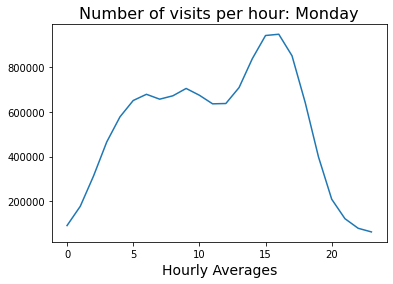

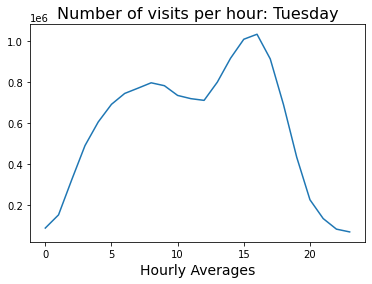

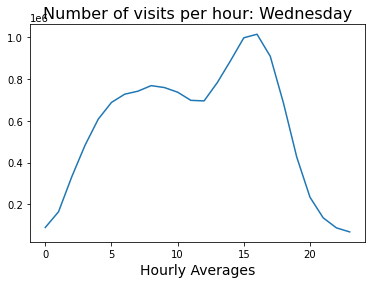

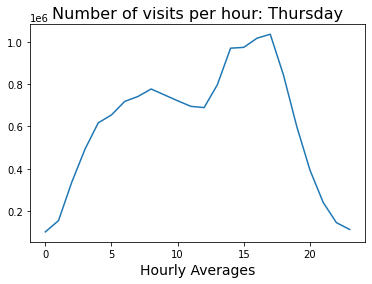

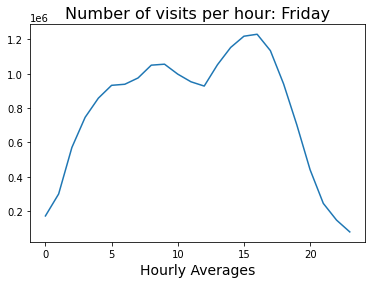

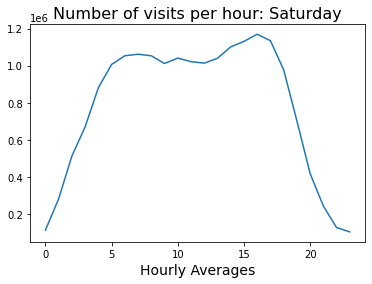

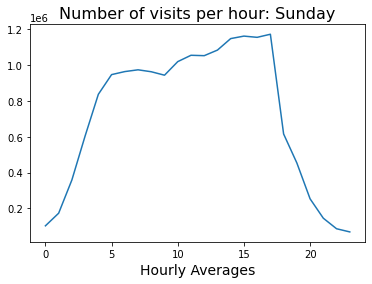

In [38]:
# First Group by Day
week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for group in data.groupby([data.event_time.dt.weekday]):
    
    #Then Group by hours for each day and count each user_session
    dfp = group[1].groupby([data.event_time.dt.hour]).user_session.count()
    wk_day = week[group[0]]
    
    #Plot
    dfp.plot()
    plt.xlabel("Hourly Averages", fontdict={'fontsize': 14}) 
    plt.title(label = str(f'Number of visits per hour: {wk_day}'), fontdict={'fontsize': 16})
    plt.show()

---

# Question 6

***The conversion rate of a product is given by the number of times a product has been bought over the number of times it has been visited. What's the conversion rate of your online store?***

# Question 6.1

***Find the overall conversion rate of your store.***

# Question 6.2

***Plot the number of purchases of each category and show the conversion rate of each category in decreasing order.***

In [39]:
a = len(data[data['event_type']=='view'])
print('The website has been visited '+str(a)+' times.')
b = len(data[data['event_type']=='purchase'])
print('There were '+str(b)+' purchases.')
print('The overall conversion rate of the store is then :', str(b/a))

The website has been visited 104335509 times.
There were 1659788 purchases.
The overall conversion rate of the store is then : 0.01590817944828352


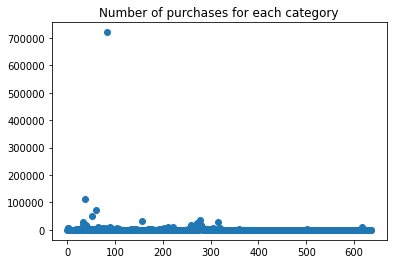

In [40]:
purch = data[data.event_type == 'purchase'].groupby('category_id').count()
purch = purch[['event_type']]
plt.scatter(np.linspace(0,len(purch),len(purch)),purch)
plt.title('Number of purchases for each category')
plt.show()

In [41]:
purch.head(5)

,event_type
category_id,
2053013552226107603,59
2053013552259662037,3965
2053013552293216471,6066
2053013552326770905,6156
2053013552351936731,1197


In [42]:
views = data[data.event_type == 'view'].groupby('category_id').count()
views = views[['event_type']]

In [43]:
L = []

# By using the length of the dataframe 'purch' (which contains all the purchases for each category), 
# we drop every category with no purchase.These have a conversion rate of 0. 
for k in range(len(purch)):
    L.append(int(purch.iloc[k])/int(views.iloc[k]))

L.sort(reverse = True)

purch['Conversion Rate'] = L

In [44]:
print('Conversion Rate of each category in decreasing order')
purch.head(10)

Conversion Rate of each category in decreasing order


,event_type,Conversion Rate
category_id,,
2053013552226107603,59,419.125000
2053013552259662037,3965,167.666667
2053013552293216471,6066,156.933333
2053013552326770905,6156,39.600000
2053013552351936731,1197,10.694444
2053013552385491165,4141,5.166667
2053013552427434207,746,3.376627
2053013552469377249,806,3.260870
2053013552502931683,79,3.230769


---

# Question 7

***The Pareto principle states that for many outcomes roughly 80% of consequences come from 20% of the causes. Also known as 80/20 rule, in e-commerce simply means that most of your business, around 80%, likely comes from about 20% of your customers. Prove that the pareto principle applies to your store.***

To answer this question, we first create a table with the relative filtered data, i.e. the sum of each user's purchases, in terms of price values. Then, we compute the total sales of the store and the total number of customers, so as to know how many customers correspond to 20% and what is the percentage of sales they have created.

In [46]:
sub_df = data.loc[:, ["event_type", "user_id", "price"]].query("event_type == 'purchase'")
all_customers = set(sub_df.user_id.dropna())
sales = pd.DataFrame(sub_df.groupby('user_id')['price'].sum()).sort_values(by= "price", 
                                                                         ascending = False)
sales.head()

,price
user_id,
512386086,344153.29
515384420,303144.24
513117637,266331.24
519267944,265569.52
518514099,203986.07


In [47]:
percentage_customer = int(0.2*len(all_customers)) #139494
tot_sales = int(sales.sum()) #505152392
sales_20perc = int(sales[0:percentage_customer].sum()) #364222233
sales_generated_20perc = round(sales_20perc/tot_sales*100, 2) #72.1%

In [48]:
print(f"20% of the online store customers create {sales_generated_20perc}% of the store's total sales.")

20% of the online store customers create 72.1% of the store's total sales.


##### It seems that the Pareto principle is satisfied, as 20% of the customers generate 72.1% of the store's sales.